# Autoencoder cf study #1
<hr style='height:5px'>
kwanki.ahn<br>
2019/06/01 skeleton<br>
2019/06/03 update model, add metrics<br>
ref : 
<hr style='height:5px'>

* Data loader

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics.pairwise import pairwise_distances

In [2]:
def get_users_items_ratings_nparray():
    # movielens dataset : https://old.datahub.io/dataset/movielens
    USERS_PATH = 'dataset/ml-1m/users.dat'
    MOVIES_PATH = 'dataset/ml-1m/movies.dat'
    RATINGS_PATH = 'dataset/ml-1m/ratings.dat'
    
    # data processing : https://github.com/khanhnamle1994/movielens/blob/master/Data_Processing.ipynb
    # Specify User's Age and Occupation Column
    AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
    OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                    4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                    12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                    17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }
    
    # Read the Ratings File
    ratings = pd.read_csv(RATINGS_PATH, 
                        sep='::', 
                        engine='python', 
                        encoding='latin-1',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

    # Set max_userid to the maximum user_id in the ratings
    max_userid = ratings['user_id'].drop_duplicates().max()
    # Set max_movieid to the maximum movie_id in the ratings
    max_movieid = ratings['movie_id'].drop_duplicates().max()

    # Process ratings dataframe for Keras Deep Learning model
    # Add user_emb_id column whose values == user_id - 1
    ratings['user_emb_id'] = ratings['user_id'] - 1
    # Add movie_emb_id column whose values == movie_id - 1
    ratings['movie_emb_id'] = ratings['movie_id'] - 1

    print len(ratings), 'ratings loaded'
    
    # Read the Users File
    users = pd.read_csv(USERS_PATH, 
                        sep='::', 
                        engine='python', 
                        encoding='latin-1',
                        names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
    users['age_desc'] = users['age'].apply(lambda x: AGES[x])
    users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
    print len(users), 'descriptions of', max_userid, 'users loaded.'
    
    # Read the Movies File
    movies = pd.read_csv(MOVIES_PATH, 
                        sep='::', 
                        engine='python', 
                        encoding='latin-1',
                        names=['movie_id', 'title', 'genres'])
    print len(movies), 'descriptions of', max_movieid, 'movies loaded.'
    
    return users, movies, ratings

In [3]:
def check_stats(users, movies, ratings):
    n_user = len(users)
    n_item = len(movies)
    n_rating = len(ratings)
    n_matrix_size = n_user * n_item
    n_sparsity = (1 - (float(n_rating) / float(n_matrix_size))) * 100
    print "users : {}, items : {}, ratings : {}, sparsity : {} %".format(n_user, n_item, n_rating, n_sparsity)
    print "user_id max : {}, movie_id max : {}".format(users['user_id'].max(), movies['movie_id'].max())
    return n_user, n_item, n_rating, n_matrix_size, n_sparsity

In [4]:
def build_dict_of_data(users, movies, ratings):
    user2idx = {}
    idx2user = {}
    movie2idx = {}
    idx2movie = {}

    for idx, row in users.iterrows():
        user2idx[row['user_id']] = idx
        idx2user[idx] = row['user_id']
    for idx, row in movies.iterrows():
        movie2idx[row['movie_id']] = idx
        idx2movie[idx] = row['movie_id']
    return user2idx, idx2user, movie2idx, idx2movie

In [5]:
def build_ratings_matrix(ratings, user2idx, movie2idx):
    r_matrix = np.zeros((n_user, n_item), dtype='i')
    for index, row in ratings.iterrows():
        user_idx = user2idx[row['user_id']]
        movie_idx = movie2idx[row['movie_id']]
        rating = row['rating']
        r_matrix[user_idx][movie_idx] = 1  # rating
    return r_matrix

* Model

In [6]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

def build_autoencoder_model(x_train, latent_size = [1000, 50]):
    # input dimension = 784
    input_dim = x_train.shape[1]
    inter_dim = latent_size[0]
    rep_dim = latent_size[1]  # latent_size  # 32

    compression_factor = float(input_dim) / rep_dim
    print("Compression factor: %s" % compression_factor)

    autoencoder = Sequential()
    autoencoder.add(
        Dense(inter_dim, input_shape=(input_dim,), activation='selu')
    )
    autoencoder.add(
        Dense(rep_dim, activation='selu')
    )
    autoencoder.add(
        Dense(inter_dim, activation='selu')
    )
    autoencoder.add(
        Dense(input_dim, activation='sigmoid')
    )

    autoencoder.summary()
    
    return autoencoder

Using TensorFlow backend.


* Verify

In [7]:
def show_history_of_user(ratings, movies, sample_user_id=100, item_number=15):
    print "== get_history_of_user(), user id = {}".format(sample_user_id)
    history_with_id_rating = (ratings.loc[ratings['user_id'] == sample_user_id][['movie_id', 'rating']]
            .sort_values(["rating"], ascending=[False])[:item_number])
    history_with_meta = pd.merge(history_with_id_rating, movies, on='movie_id')
    return history_with_meta

In [8]:
def get_recommend_of_user_raw(model, r_matrix, user2idx, movies, sample_user_id=100, debug=False):
    if debug is True:
        print "== get_recommend_of_user_raw(), user id = {}".format(sample_user_id)
    # reshape 1 by x => x by 1
    history_of_user = r_matrix[user2idx[sample_user_id]]
    shape_len = history_of_user.shape[0]
    history_of_user = history_of_user.reshape((1, shape_len))
    score_list = model.predict(history_of_user).flatten()
    if debug is True:
        print "  result raw : shape = {}, max = {}, min = {}".format(score_list.shape, score_list.max(), score_list.min())
    return score_list

In [9]:
def get_watched_remove(recommends_raw, r_matrix, user2idx, idx2movie, sample_user_id=100):
    print "== get_watched_remove() =="
    
    # remove watched
    rating_of_user = r_matrix[user2idx[sample_user_id]]
    print rating_of_user.shape

    recommends_watch_removed = []
    for idx in range(0, len(recommends_raw)):
        if rating_of_user[idx] == 0:  # FALSE == if user watched idx program already
            recommends_watch_removed.append((idx2movie[idx], recommends_raw[idx]))
            
    return recommends_watch_removed

In [10]:
def show_recommend_of_user(model, r_matrix, user2idx, idx2movie, movies, sample_user_id=100, item_number=15):
    print "== get_recommend_of_user(), user id : {} ==".format(sample_user_id)
    # model's output (raw) : list of scores, length is item count, from index 0 (idx2movie needs)
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, sample_user_id)
    
    # remove watched (from rating matrix, allow only if not rating score is 0) -> [(movie id, score)]
    remove_watched = get_watched_remove(recommends_raw, r_matrix, user2idx, idx2movie, sample_user_id)
    
    # select top n
    from operator import itemgetter
    remove_watched.sort(key=itemgetter(1), reverse=True)
    remove_watched = remove_watched[:item_number]

    recommend_df = pd.DataFrame(np.array(remove_watched))
    recommend_df.columns = ['movie_id', 'inferred_score']
    recommend_df = recommend_df.astype({"movie_id": int, "inferred_score": float})
    recommend_with_meta = pd.merge(recommend_df, movies, on='movie_id')
    return recommend_with_meta

# MAIN

## DATA

In [11]:
users, movies, ratings = get_users_items_ratings_nparray()

1000209 ratings loaded
6040 descriptions of 6040 users loaded.
3883 descriptions of 3952 movies loaded.


In [12]:
ratings[:10]

,user_id,movie_id,rating,timestamp,user_emb_id,movie_emb_id
0,1,1193,5,978300760,0,1192
1,1,661,3,978302109,0,660
2,1,914,3,978301968,0,913
3,1,3408,4,978300275,0,3407
4,1,2355,5,978824291,0,2354
5,1,1197,3,978302268,0,1196
6,1,1287,5,978302039,0,1286
7,1,2804,5,978300719,0,2803
8,1,594,4,978302268,0,593
9,1,919,4,978301368,0,918


In [13]:
users[:10]

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer
5,6,F,50,9,55117,50-55,homemaker
6,7,M,35,1,06810,35-44,academic/educator
7,8,M,25,12,11413,25-34,programmer
8,9,M,25,17,61614,25-34,technician/engineer
9,10,F,35,1,95370,35-44,academic/educator


In [14]:
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [15]:
n_user, n_item, n_rating, n_matrix_size, n_sparsity = check_stats(users, movies, ratings)
user2idx, idx2user, movie2idx, idx2movie = build_dict_of_data(users, movies, ratings)
len(user2idx), len(idx2user), len(movie2idx), len(idx2movie)

users : 6040, items : 3883, ratings : 1000209, sparsity : 95.735320202 %
user_id max : 6040, movie_id max : 3952


(6040, 6040, 3883, 3883)

In [16]:
r_matrix = build_ratings_matrix(ratings, user2idx, movie2idx)

In [17]:
# UNIT TEST
# user_id_test = 3491
# history = (ratings.loc[ratings['user_id'] == user_id_test][['movie_id', 'rating']]
#             .sort_values(["rating"], ascending=[False])[:20])
# history
# compare history vs ratings raw data file 45's rating scores

## MODEL

In [18]:
autoencoder = build_autoencoder_model(r_matrix, latent_size = [1000, 50])

Compression factor: 77.66
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              3884000   
_________________________________________________________________
dense_2 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              51000     
_________________________________________________________________
dense_4 (Dense)              (None, 3883)              3886883   
Total params: 7,871,933
Trainable params: 7,871,933
Non-trainable params: 0
_________________________________________________________________


In [160]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(r_matrix, r_matrix,
                epochs=60,
                batch_size=256,
                shuffle=True
                # validation_data=(x_test, x_test)
               )

Epoch 1/60
6040/6040 [==============================] - 5s - loss: 0.0215     
Epoch 2/60
6040/6040 [==============================] - 5s - loss: 0.0200     
Epoch 3/60
6040/6040 [==============================] - 5s - loss: 0.0196     
Epoch 4/60
6040/6040 [==============================] - 5s - loss: 0.0194     
Epoch 5/60
6040/6040 [==============================] - 5s - loss: 0.0193     
Epoch 6/60
6040/6040 [==============================] - 5s - loss: 0.0191     
Epoch 7/60
6040/6040 [==============================] - 5s - loss: 0.0190     
Epoch 8/60
6040/6040 [==============================] - 5s - loss: 0.0188     
Epoch 9/60
6040/6040 [==============================] - 5s - loss: 0.0186     
Epoch 10/60
6040/6040 [==============================] - 5s - loss: 0.0185     
Epoch 11/60
6040/6040 [==============================] - 5s - loss: 0.0183     
Epoch 12/60
6040/6040 [==============================] - 5s - loss: 0.0181     
Epoch 13/60
6040/6040 [==========================

## VERIFY (eye checking)

In [161]:
show_history_of_user(ratings, movies, sample_user_id=45)

== get_history_of_user(), user id = 45


,movie_id,rating,title,genres
0,915,5,Sabrina (1954),Comedy|Romance
1,3044,5,Dead Again (1991),Mystery|Romance|Thriller
2,969,5,"African Queen, The (1951)",Action|Adventure|Romance|War
3,46,5,How to Make an American Quilt (1995),Drama|Romance
4,357,5,Four Weddings and a Funeral (1994),Comedy|Romance
5,440,5,Dave (1993),Comedy|Romance
6,1835,5,City of Angels (1998),Romance
7,2716,5,Ghostbusters (1984),Comedy|Horror
8,2779,5,Heaven Can Wait (1978),Comedy
9,587,5,Ghost (1990),Comedy|Romance|Thriller


In [162]:
show_recommend_of_user(autoencoder, r_matrix, user2idx, idx2movie, movies, sample_user_id=45)

== get_recommend_of_user(), user id : 45 ==
== get_watched_remove() ==
(3883,)


,movie_id,inferred_score,title,genres
0,1569,1.000000,My Best Friend's Wedding (1997),Comedy|Romance
1,351,1.000000,"Corrina, Corrina (1994)",Comedy|Drama|Romance
2,236,1.000000,French Kiss (1995),Comedy|Romance
3,597,0.999999,Pretty Woman (1990),Comedy|Romance
4,356,0.999998,Forrest Gump (1994),Comedy|Romance|War
5,1777,0.999984,"Wedding Singer, The (1998)",Comedy|Romance
6,1643,0.999963,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",Drama|Romance
7,21,0.999960,Get Shorty (1995),Action|Comedy|Drama
8,342,0.999895,Muriel's Wedding (1994),Comedy|Romance
9,1393,0.999877,Jerry Maguire (1996),Drama|Romance


## METRIC

### AUC
<hr style='height:5px'>

In [163]:
def get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug=False):
    watched_l = []
    nowatched_l = []
    user_history = r_matrix[user2idx[user_id]]  # rating (watched) history
    for idx, r, in enumerate(user_history):
        if r != 0:
            watched_l.append(idx2movie[idx])
        else:
            nowatched_l.append(idx2movie[idx])
    if debug is True:
        print "  watched_l : {}..., len : {}".format(watched_l[:10], len(watched_l))
        print "  nowatched_l : {}..., len : {}".format(nowatched_l[:10], len(nowatched_l))
    return watched_l, nowatched_l

In [164]:
def get_auc_score(user_id, model, r_matrix, user2idx, idx2movie, movies, item_k=100, debug=False):
    # refer : http://hyunje.com/data%20analysis/2015/07/27/advanced-analytics-with-spark-ch3-2/
    # corrent = number of 본것's predict rating > 안본것's predict rating
    # auc = correct / total test number
    
    if debug is True:
        print "get_auc_score() start, user id : {}".format(user_id)
        
    watched_l, nowatched_l = get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug=False)
    candidate_len = min(len(watched_l), len(nowatched_l))
    if item_k > candidate_len:
        item_k = candidate_len
    if debug is True:
        print "  candidate_len : {}, item_k : {}".format(candidate_len, item_k)
    
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, user_id)

    import random
    random_index_l = random.sample(range(0, candidate_len), item_k) 
    watched_sample_k = [watched_l[x] for x in random_index_l]
    nowatched_sample_k = [nowatched_l[x] for x in random_index_l]
    
    if debug is True:
        print "  watched_sample_k : {}..., len : {}".format(watched_sample_k[:10], len(watched_sample_k))
        print "  nowatched_sample_k : {}..., len : {}".format(nowatched_sample_k[:10], len(nowatched_sample_k))
    
    correct = 0
    for i in range(0, item_k):
        if recommends_raw[movie2idx[watched_sample_k[i]]] > recommends_raw[movie2idx[nowatched_sample_k[i]]]:
            correct += 1
    return float(correct) / float(item_k)

In [165]:
# AUC SCORE of single person
get_auc_score(45, autoencoder, r_matrix, user2idx, idx2movie, movies, item_k=150)

0.9866666666666667

In [166]:
# AUC SCORE of 500 person average
k = 500
import random
r_user_idx = random.sample(range(0, len(users)), k)

auc_agg = []
for u in r_user_idx:
    auc_agg.append(get_auc_score(idx2user[u], autoencoder, r_matrix, user2idx, idx2movie, movies, item_k=150))

== STATS ==
  AUC : 0.928612328195 (avg of 500 users)
  max : 1.0, min : 0.72, median : 0.939393939394


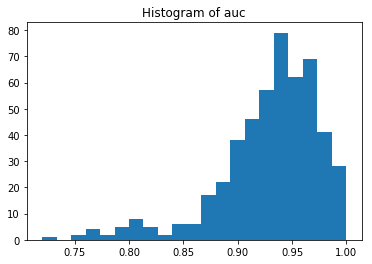

In [167]:
print "== STATS =="
print "  AUC : {} (avg of {} users)".format(np.average(auc_agg), k)
print "  max : {}, min : {}, median : {}".format(max(auc_agg), min(auc_agg), np.median(auc_agg))
plt.hist(auc_agg, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of auc")
plt.show()

### TOP K ACCURACY
<hr style='height:5px'>

In [168]:
def check_watched_item_score_is_in(recommends_raw, watched_l, nowatched_l, candidate_len, idx2movie, k, base, debug=False):
    import random
    random_index_l = random.sample(range(0, candidate_len), base) 
    watched_sample_1 = [watched_l[x] for x in random_index_l][0]
    nowatched_sample_99 = [nowatched_l[x] for x in random_index_l][:base-1]
    
    if debug is True:
        print "  watched_sample_k : {}..., len : {}".format(watched_sample_k[:10], len(watched_sample_k))
        print "  nowatched_sample_k : {}..., len : {}".format(nowatched_sample_k[:10], len(nowatched_sample_k))
    
    # sorted nowatch 99 score
    scores = []
    for i in nowatched_sample_99:
        scores.append(recommends_raw[movie2idx[i]])
    scores.sort(reverse=True)
    
    # watched 1 score
    score_watched = recommends_raw[movie2idx[watched_sample_1]]
    if score_watched >= scores[k]:
        return True
    return False

In [169]:
def get_topk_accuracy(user_id, model, r_matrix, user2idx, idx2movie, movies, k = 10, base=100, debug=False):
    if debug is True:
        print "get_topk_accuracy() start, user id : {}".format(user_id)
        
    watched_l, nowatched_l = get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug=False)
    candidate_len = min(len(watched_l), len(nowatched_l))
    if base > candidate_len:
        base = candidate_len
    if debug is True:
        print "  candidate_len : {}, k : {}, base : {}".format(candidate_len, k, base)
        
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, user_id)
    
    hit = 0
    for i in range(0, 100):  # single person, 100 iteration (-> picking 1 watch, 99 nowatch (1 + 99 = # of base), and check watched is under k-th order)
        if check_watched_item_score_is_in(recommends_raw, watched_l, nowatched_l, candidate_len, idx2movie, k, base, debug=False) is True:
            hit += 1
    return float(hit) / float(100) 

In [170]:
# TOP K Score of single person
get_topk_accuracy(45, autoencoder, r_matrix, user2idx, idx2movie, movies, k=10, base=100, debug=True)

get_topk_accuracy() start, user id : 45
  candidate_len : 297, k : 10, base : 100


0.9

In [171]:
# TOP K SCORE of 500 person average
k = 500
import random
r_user_idx = random.sample(range(0, len(users)), k)

score_agg = []
for u in r_user_idx:
    score_agg.append(get_topk_accuracy(idx2user[u], autoencoder, r_matrix, user2idx, idx2movie, movies, k=10, base=100, debug=False))

== STATS ==
  TOP-K ACCURACY : 0.8735 (avg of 500 users)
  max : 1.0, min : 0.51, median : 0.89


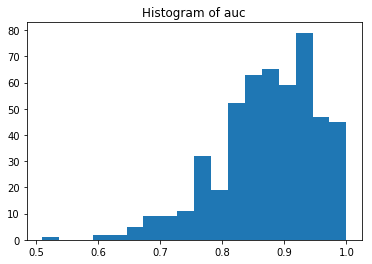

In [172]:
print "== STATS =="
print "  TOP-K ACCURACY : {} (avg of {} users)".format(np.average(score_agg), k)
print "  max : {}, min : {}, median : {}".format(max(score_agg), min(score_agg), np.median(score_agg))
plt.hist(score_agg, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of auc")
plt.show()

### HIT RATION@K
<hr style='height:5px'>

In [173]:
def check_howmany_watched_is_recommended(recommends_raw_with_index, watched_l, nowatched_l, candidate_len, idx2movie, base, debug=True):
    if debug is True:
        print "check_top_n_includes_watched() start"
        print "  watched_l : {}".format(watched_l)
        
    hit = 0
    for index, score in recommends_raw_with_index:
        if debug is True:
            print "  checking index : {} (idx2movie -> {}), score : {}".format(index, idx2movie[index], score)
        if idx2movie[index] in watched_l:
            if debug is True:
                print "hit!!! "
            hit += 1
    return float(hit) / float(len(watched_l))

In [174]:
def get_hitratio_n(user_id, model, r_matrix, user2idx, idx2movie, movies, base=100, debug=False):
    if debug is True:
        print "get_hitration_n() start, user id : {}".format(user_id)
        
    watched_l, nowatched_l = get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug)
    candidate_len = min(len(watched_l), len(nowatched_l))
    if base > candidate_len:
        base = candidate_len
    if debug is True:
        print "  candidate_len : {}, base : {}".format(candidate_len, base)
        
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, user_id)
    recommends_raw_with_index = [(idx, score) for idx, score in enumerate(recommends_raw)]
    from operator import itemgetter
    recommends_raw_with_index.sort(key=itemgetter(1), reverse=True)
    
    if debug is True:
        print "recommends_raw_with_index[:{}] is : {}".format(base, recommends_raw_with_index[:base])
    
    score = check_howmany_watched_is_recommended(recommends_raw_with_index[:base], watched_l, nowatched_l, candidate_len, idx2movie, base, debug)
    return score

In [175]:
# HR@K Score of single person
HRK = 200
get_hitratio_n(45, autoencoder, r_matrix, user2idx, idx2movie, movies, base=HRK, debug=False)

0.622895622895623

In [176]:
# HR@K SCORE of 500 person average
k = 500
import random
r_user_idx = random.sample(range(0, len(users)), k)

score_agg = []
for u in r_user_idx:
    score_agg.append(get_hitratio_n(idx2user[u], autoencoder, r_matrix, user2idx, idx2movie, movies, base=HRK, debug=False))

== STATS ==
  HR@200 ACCURACY : 0.661361306872 (avg of 500 users)
  max : 0.942857142857, min : 0.137254901961, median : 0.696457821458


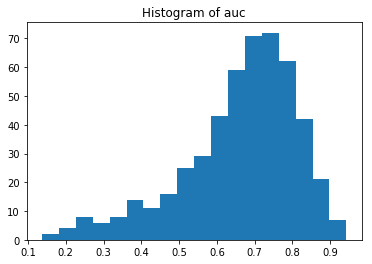

In [177]:
print "== STATS =="
print "  HR@{} ACCURACY : {} (avg of {} users)".format(HRK, np.average(score_agg), k)
print "  max : {}, min : {}, median : {}".format(max(score_agg), min(score_agg), np.median(score_agg))
plt.hist(score_agg, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of auc")
plt.show()